In [1]:
from GeneralUse import *
from ArrayToRTKConversion import *
from RTKToArrayConversion import * 
from ConeBeamDccWithBackProjectionPlane import *
from ConditionOfApplicability import *
from ShortestPaths import *
from tqdm import tqdm_notebook

In [2]:
#Choose projections file and geometry file
projFile = ""
geoFile = ""

#Read the projections
proj = itk.imread(projFile)

#Read the geometry
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(geoFile)
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()

In [3]:
#Convert to array for faster computation
geometryArray = RTKtoNP(geometry)
projArray = itk.GetArrayFromImage(proj)
projSpacing, projOrigin, projSize, projDirection = GetProjectionInformations(proj)
print(projSpacing, projOrigin, projSize)
#print some parameters
print(ExtractGeometricParameters(geometryArray, projSize, projSpacing))

[1.28583918 1.2        1.        ] [0. 0. 0.] [   736     16 234110]
([0.164907559919826, -4.46, 0], 204, 1152, 1.740000000000009, 0.09062500000000048, 251.2126886870379)


In [4]:
#Under sample the stack
projSub, geometrySub, projSubArray, geometrySubArray = SubsampleAcquisition(geometryArray, projArray, projSpacing, projOrigin, projSize, projDirection) # Number of sampled is 20 per rotation
projSpacing, projOrigin, projSize, projDirection = GetProjectionInformations(projSub)
print(projSpacing, projOrigin, projSize)
nproj = projSize[2]
center, nb_rotations, nb_proj_per_rotations, d, pitch, r_fov = ExtractGeometricParameters(geometrySubArray, projSize, projSpacing)
print(center, nb_rotations, nb_proj_per_rotations, d, pitch, r_fov, nproj)
#And extract the necessary other parameters
sourcePositions = GetSourcePositions(geometrySub)
rotationMatrices = GetRotationMatrices(geometrySub)
FixedSystemMatrices = GetFixedSystemMatrices(geometrySub)

[1.28583918 1.2        1.        ] [0. 0. 0.] [ 736   16 4065]
[0.164907559919826, -4.42, 0] 204 20 1.740000000000009 0.09062500000000048 251.21268268493873 4065


In [5]:
#Compute the all pairs possible in the acquisition
s0L = np.arange(nb_proj_per_rotations*nb_rotations//2,nb_proj_per_rotations*(nb_rotations//2+1))
rangeList=[]
results = []
j = -1 
for s0 in tqdm_notebook(s0L):
    data = [i for i in np.arange(nproj) if i!=s0]
    results.append([])
    j+=1
    for s1 in data:
        r = CheckPairGeometry(geometrySubArray, geometrySubArray[9,0], sourcePositions, rotationMatrices, FixedSystemMatrices, projDirection, projOrigin, projSize, projSpacing, s0, s1)
        results[j].append(r)
for j in range(len(results)):
    rangeList.append([k for k in results[j] if k!=0])
    rangeList[j].sort()

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [6]:
#Compute the DCC
ListOfPairs = []
distances = []
for i in tqdm_notebook(range(nproj)):
    pairs,d =  computeDCCidx(projSubArray, projSpacing, projOrigin, projSize, projDirection, rangeList[i%nb_proj_per_rotations], geometrySubArray, i)
    ListOfPairs.append(pairs)
    distances.append(d)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [7]:
#Compute shortest paths
G = ComputeGraphAfterDCC(ListOfPairs,distances)
destinations, distances = PlotGraphOneSourceInit(G, 0, nproj)

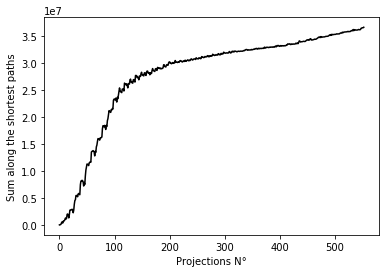

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(destinations, distances, 'k')
plt.xlabel("Projections N°")
plt.ylabel("Sum along the shortest paths")
plt.show()

In [9]:
from joblib import Parallel, delayed
import time

start = time.time()
res = Parallel(n_jobs=8)(delayed(computeDCCidx)(projSubArray, projSpacing, projOrigin, projSize, projDirection, rangeList[i%nb_proj_per_rotations], geometrySubArray, i)  for i in range(nproj))

print(time.time()-start)

563.9034082889557


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


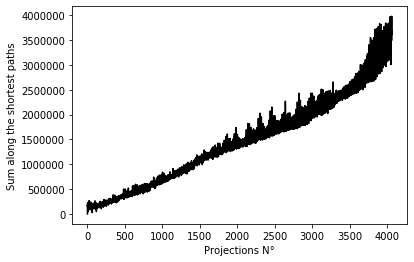

In [10]:
lof = []
dist = []
for i in tqdm_notebook(range(nproj)): 
    lof.append([])
    dist.append([])
    for j in range(len(res[i][0])):
        lof[i].append(res[i][0][j])
        dist[i].append(res[i][1][j])

G = ComputeGraphAfterDCC(lof,dist)
destinations, distances = PlotGraphOneSourceInit(G, 0, nproj)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(destinations, distances, 'k')
plt.xlabel("Projections N°")
plt.ylabel("Sum along the shortest paths")
plt.show()

553
553
